# Projekt IAU 2021, fáza 2 - predspracovanie údajov
Autori: **Matúš Krajčovič**, **Michal Kuklovský**

Podiel práce: obaja 50%

## Zadanie

V tejto fáze sa od Vás očakáva:
  - Realizujte predspracovanie údajov pre strojové učenie. Výsledkom bude upravená dátová sada vo formáte csv alebo tsv, kde jedno pozorovanie musí byť opísané jedným riadkom.
  - V 3. fáze budeme pracovať s algoritmami strojového učenia, ktorých implementácia v scikit-learn podporuje len numerické dáta. To vedie k tomu že treba niečo spraviť s nenumerickými dátami.
  - Replikovateľnosť predspracovania na trénovacej a testovacej množine dát.

Keď sa predspracovaním mohol zmeniť tvar a charakteristiky dát (počet atribútov, distribúcie hodnôt a pod.), je možné že treba znovu zrealizovať podstatné časti prieskumnej analýzy a opakovane podľa Vašej potreby. Bodovanie znovu za EDA už nebudeme, zmeny ale zdokumentujte. Problém s dátami môžete riešiť iteratívne v každej fáze aj vo všetkých fázach podľa vlastnej potreby.

1. **Integrácia a čistenie dát (5b)**

  Transformujte dáta na vhodný formát pre strojové učenie t.j. jedno pozorovanie musí byť opísané jedným riadkom a každý atribút musí byť v numerickom formáte. 
  - Pri riešení chýbajúcich hodnôt (missing values) vyskúšajte rôzne stratégie z nasledujúcich podskupín:
    - odstránenie pozorovaní s chýbajúcimi údajmi
    - nahradenie chýbajúcej hodnoty mediánom, priemerom, pomerom (ku korelovanému atribútu), alebo pomocou lineárnej regresie resp. kNN
  - Podobne postupujte aj pri riešení vychýlených hodnôt (outlier detection):
    - odstránenie vychýlených (odľahlých) pozorovaní
    - nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5% resp. 95%)


2. **Realizácia predspracovania dát (5b)**
  - Transformované dáta pre strojové učenie si rozdeľuje na trénovaciu a testovaciu množinu (train and test dataset) podľa vami preddefinovaným pomerom. Naďalej pracujte len s trénovacím datasetom.
  - Transformujte atribútov dát pre strojové učenie podľa dostupných techník (minimálne 2 techniky) ako scaling, transformers a ďalšie.
  - Zdôvodnite Vašu voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)


3. **Výber atribútov pre strojové učenie (5b)**
  - Zistite ktoré atribúty (features) vo vašich dátach pre strojové učenie sú informatívne k atribútu “indikator”. Zoradíte tie atribúty v poradí podľa dôležitosti. 
  - Zdôvodnite Vašu voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)


4. **Replikovateľnosť predspracovania (5b)**
  - Upravte váš kód realizujúci predspracovanie trénovacej množiny tak, aby ho bolo možné bez ďalších úprav znovu použiť na predspracovanie testovacej množiny (napr. pomocou funkcie/í)
  - Očakáva sa aj využitie možnosti sklearn.pipeline

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import date

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold

from sklearn.pipeline import Pipeline

from category_encoders import OrdinalEncoder

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import RobustScaler

import scipy.stats as stats
import statsmodels.api as sm

from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import chi2

from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_regression

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

## Pôvodné úpravy datasetu z fázy 1

In [2]:
labor = pd.read_csv("045/labor.csv", sep='\t', index_col=0)
profiles = pd.read_csv("045/profiles.csv", sep='\t', index_col=0)
labor['smoker'] = labor['smoker'].str.replace('no', 'N')
labor['smoker'] = labor['smoker'].str.replace('yes', 'Y')
labor['relationship'] = labor['relationship'].str.replace('nop', 'single')
labor.rename(columns = {'erytrocyty':'erytrocytes', 'leukocyty':'leukocytes', 'trombocyty': 'trombocytes', 'hematokrit':'hematocrit', 'er-cv': 'ercv'}, inplace = True)
profiles['birthdate'] = pd.to_datetime(profiles.birthdate)
profiles['age'] = (pd.to_datetime(date.today()) - profiles['birthdate'])
profiles['age'] = profiles['age'] / np.timedelta64(1, 'Y')
profiles['race'] = profiles['race'].str.replace('blsck', 'Black')
profiles['race'] = profiles['race'].str.replace('black', 'Black')
profiles['race'] = profiles['race'].str.replace('white', 'White')
profiles = profiles.rename(columns={'blood_group' : 'blood_type'})

## 1  Integrácia a čistenie dát

### 1.1 Missing values

Uložíme pôvodné datasety a vytvoríme nové, bez stĺpcov, ktoré nás nezaujímajú.

In [3]:
old_labor = labor.copy(deep=True)
old_profiles = profiles.copy(deep=True)

labor = labor.drop(columns=['name'])
profiles = profiles.drop(columns=['current_location', 'birthdate', 'name', 'address', 'residence'])

Pripravíme si stĺpce, s ktorými budeme pracovať pri hľadaní outlierov a NaN hodnôt.

In [4]:
numeric_cols = ['ercv', 'erytrocytes', 'hemoglobin', 'ast', 'leukocytes', 'alp', 'etytr', 'alt', 'hbver', 'hematocrit', 'weight', 'trombocytes']
num_labor = pd.DataFrame(labor[numeric_cols])

Funkcie na zobrazovanie výsledkov a tranformácie.

In [5]:
def shape_diff(data1, data2):
    print('Before: ' + str(data1.shape) + '\n' + 'After: ' + str(data2.shape))

def dist_diff(df1, df2):
    for i in df1.columns:
        f, (ax_box1, ax_box2, ax_hist) = plt.subplots(3, sharex=True, gridspec_kw={"height_ratios": (.15, .15, .70)})
        sns.boxplot(x=df1[i], ax=ax_box1)
        sns.boxplot(x=df2[i], ax=ax_box2)
        ax_box1.set(xlabel=' ')
        ax_box2.set(xlabel=' ')
        sns.histplot(df1[i], ax=ax_hist, color='b', alpha=0.5)
        sns.histplot(df2[i], ax=ax_hist, color='y', alpha=0.5)

def transform_with_pipe(pipe, df):
    new_labor = pd.DataFrame(pipe.fit_transform(df))
    new_labor.columns=df.columns
    new_labor.index=df.index
    return new_labor

def transform_to_df(arr, df):
    new_labor = pd.DataFrame(arr)
    new_labor.columns=df.columns
    new_labor.index=df.index
    return new_labor

def replace_in_df(cols, df, new_df):
    for i in cols:
        df.loc[:,i] = new_df.loc[:,i]

#### 1.1.1 Odstránenie NaN hodnôt

NaN hodnoty jednoducho odstránime z datasetu a vypíšeme výsledky.

Before: (10030, 12)
After: (9708, 12)


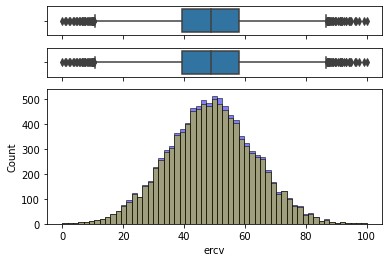

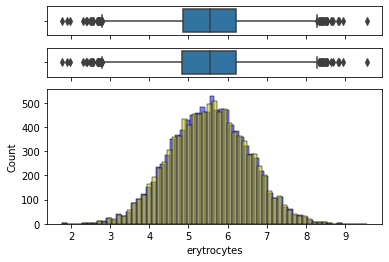

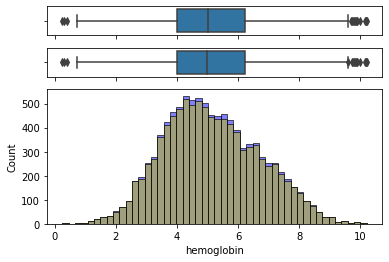

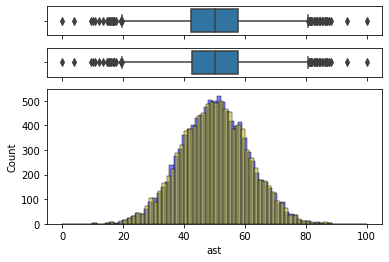

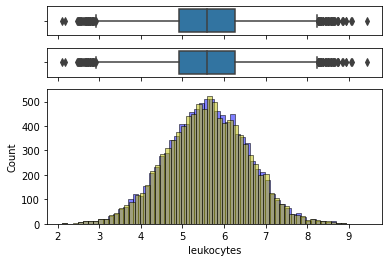

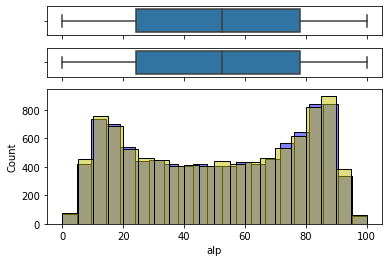

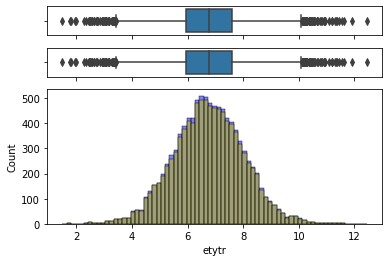

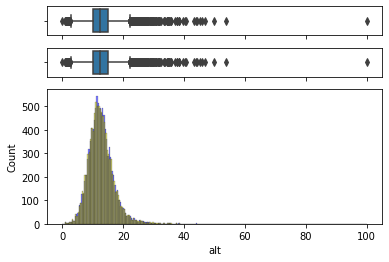

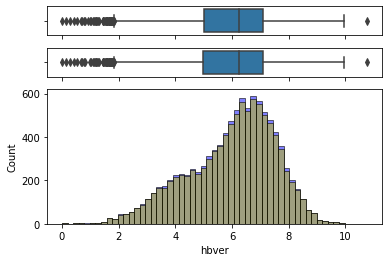

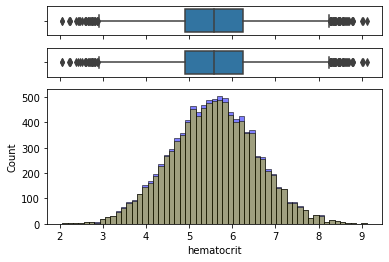

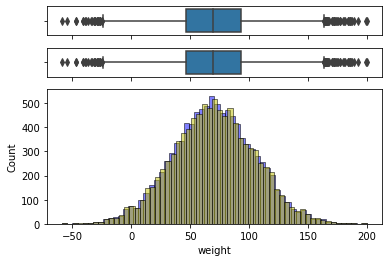

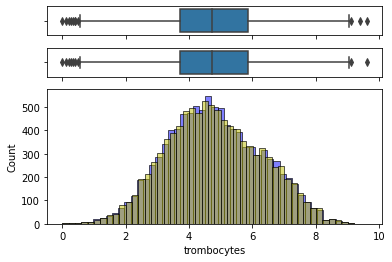

In [6]:
new_labor_dropNaN = num_labor.dropna()

shape_diff(num_labor, new_labor_dropNaN)
dist_diff(num_labor, new_labor_dropNaN)

<AxesSubplot:xlabel='hemoglobin', ylabel='alp'>

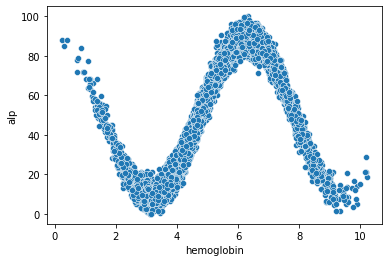

In [7]:
sns.scatterplot(data=new_labor_dropNaN, x='hemoglobin', y='alp')

#### 1.1.2 Štatistická imputácia

##### 1.1.2.1 Priemer

Použijeme jednoduchý imputer so stratégiou priemeru.

Before: (10030, 12)
After: (10030, 12)


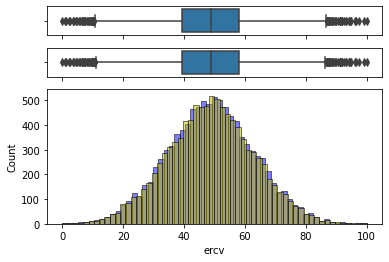

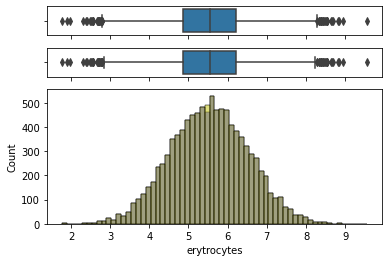

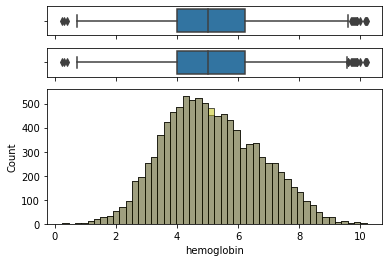

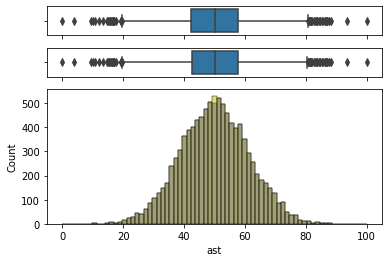

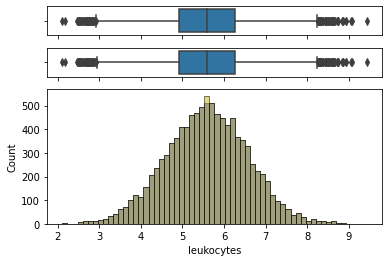

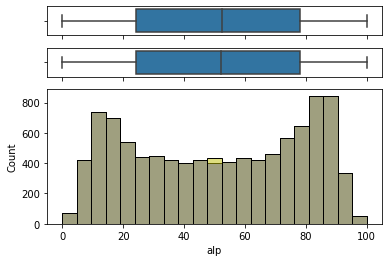

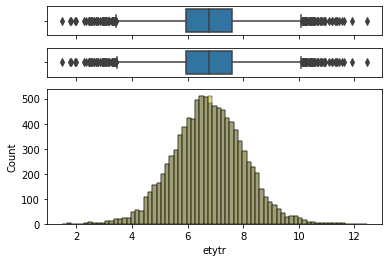

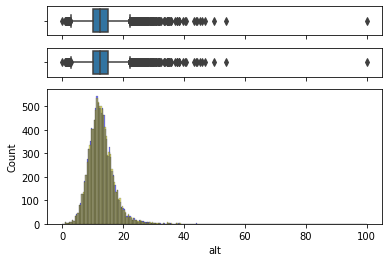

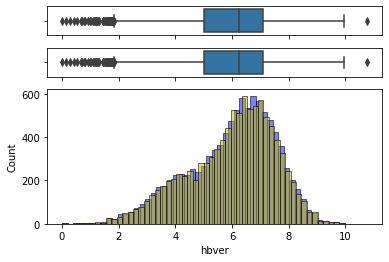

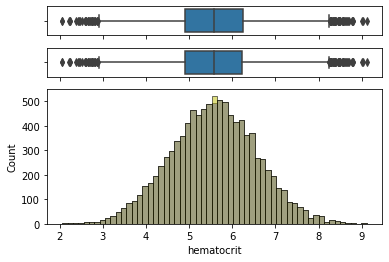

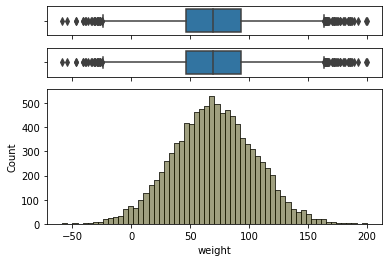

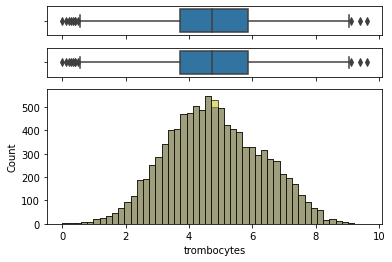

In [8]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

pipeline_mean = Pipeline(steps=[('imputer', imp_mean)])
new_labor_imp_mean = transform_with_pipe(pipeline_mean, num_labor)

shape_diff(num_labor, new_labor_imp_mean)
dist_diff(num_labor, new_labor_imp_mean)

<AxesSubplot:xlabel='hemoglobin', ylabel='alp'>

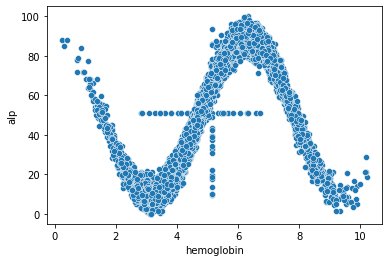

In [9]:
sns.scatterplot(data=new_labor_imp_mean, x='hemoglobin', y='alp')

##### 1.1.2.2 Medián

Použijeme jednoduchý imputer so stratégiou mediánu.

Before: (10030, 12)
After: (10030, 12)


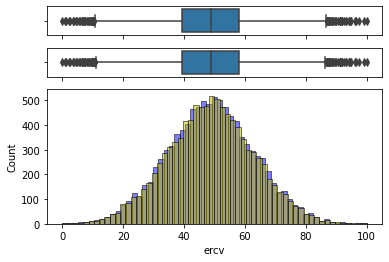

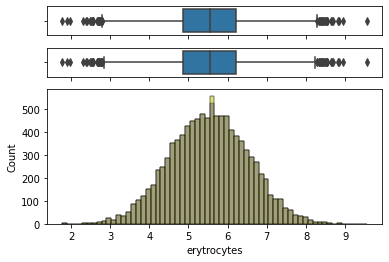

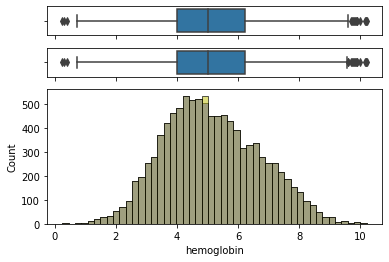

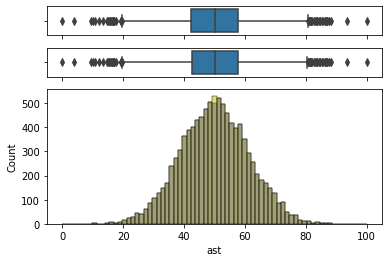

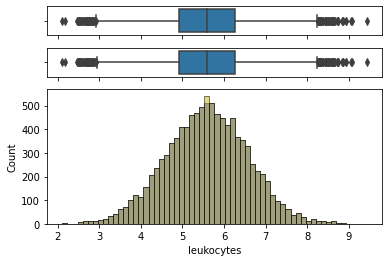

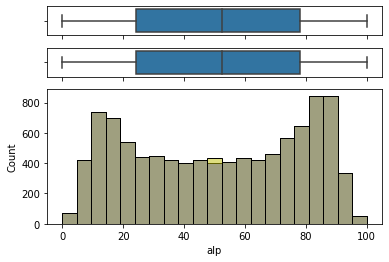

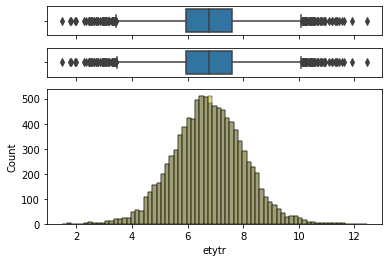

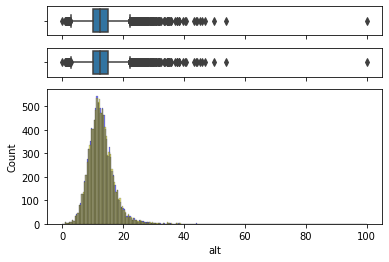

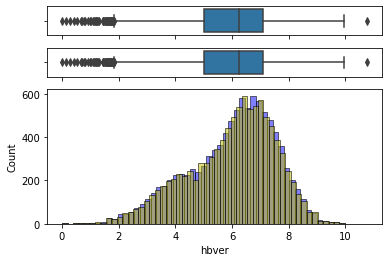

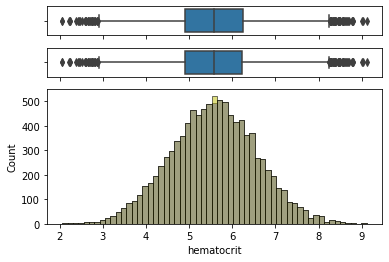

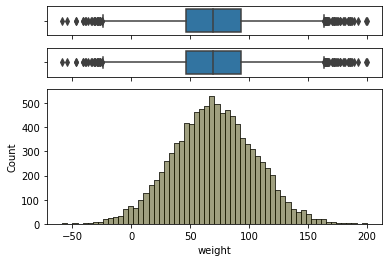

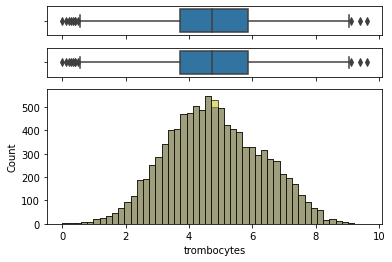

In [10]:
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')

pipeline_median = Pipeline(steps=[('imputer', imp_median)])
new_labor_imp_median = transform_with_pipe(pipeline_median, num_labor)

shape_diff(num_labor, new_labor_imp_median)
dist_diff(num_labor, new_labor_imp_median)

<AxesSubplot:xlabel='hemoglobin', ylabel='alp'>

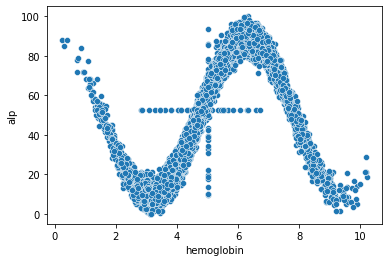

In [11]:
sns.scatterplot(data=new_labor_imp_median, x='hemoglobin', y='alp')

##### 1.1.2.3 kNN Imputer

Požijeme kNN imputer, ktorý dopĺňa na základe k najbližších susedov.

Before: (10030, 12)
After: (10030, 12)


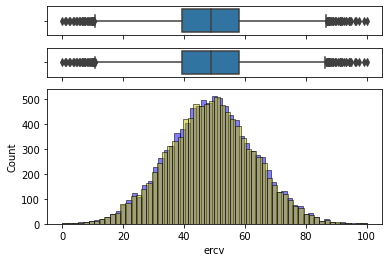

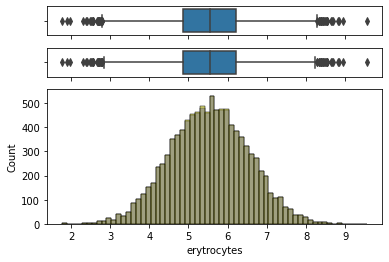

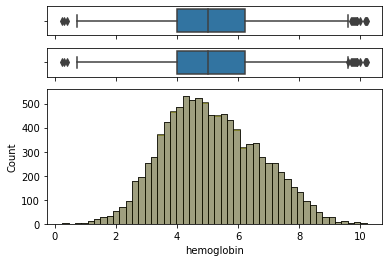

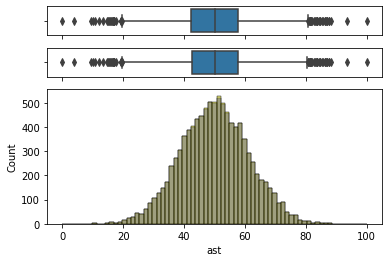

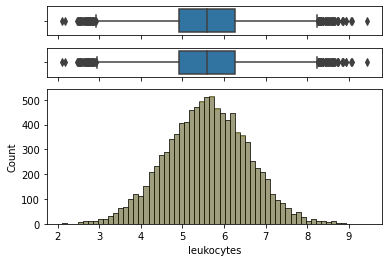

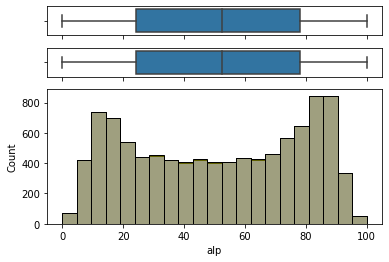

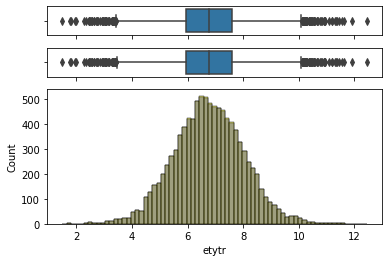

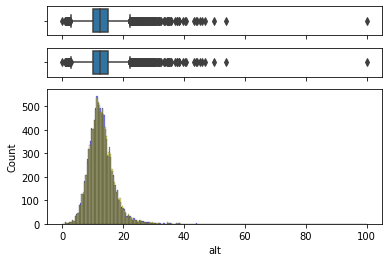

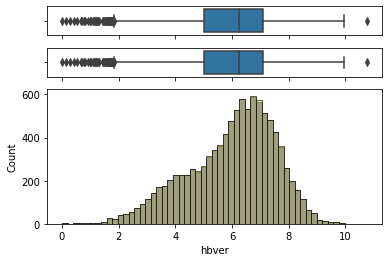

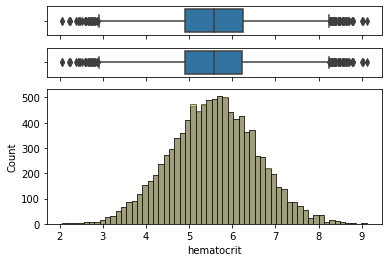

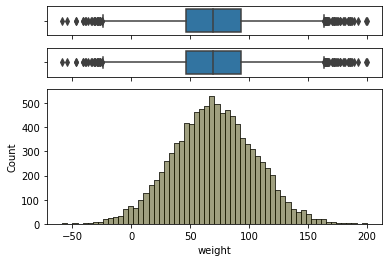

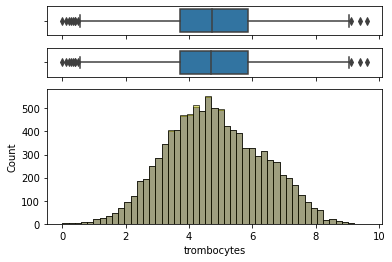

In [12]:
imp_knn = KNNImputer()

pipeline_knn = Pipeline(steps=[('imputer', imp_knn)])
new_labor_imp_knn = transform_with_pipe(pipeline_knn, num_labor)

shape_diff(num_labor, new_labor_imp_knn)
dist_diff(num_labor, new_labor_imp_knn)

<AxesSubplot:xlabel='hemoglobin', ylabel='alp'>

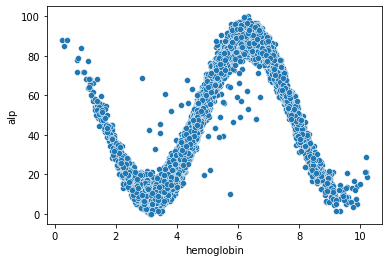

In [13]:
sns.scatterplot(data=new_labor_imp_knn, x='hemoglobin', y='alp')

#### 1.1.3  Závery

Pri všetkých štatistických imputáciách sa trochu rozbila závistosť hemoglobínu od alp, najmä pri jednoduchých inputeroch. Rozloženia atribútov zostávajú podobné pri všetkých typoch doplňovania. 
Rozhodli sme sa využiť dopĺňanie hodnôt pomocou KNN.

In [14]:
num_labor = transform_with_pipe(pipeline_knn, num_labor)
replace_in_df(numeric_cols, labor, num_labor)

### 1.2  Outlier detection

In [15]:
def detect_outliers(df, l, u):
    for i in df:
        outliers = [j for j in df[i] if j < l[i] or j > u[i]] 
        print(i + " "*(20-len(i)) + "outliers: " + str(len(outliers)))

def replace_outliers(df, l, u, lp, up):
    new_labor = df.copy(deep=True)
    for i in df:
        new_labor.loc[new_labor[i] < l[i], i] = lp[i]
        new_labor.loc[new_labor[i] > u[i], i] = up[i]
    return new_labor

def remove_outliers(df, l, u):
    new_labor = df.copy(deep=True)
    for i in df:
        new_labor = new_labor.loc[new_labor[i] >= l[i]]
        new_labor = new_labor.loc[new_labor[i] <= u[i]]
    return new_labor

#### 1.2.1  Standard Deviation Method

Použijeme metódu, v ktorej detekujeme outlierov na základe ich priemeru a odchýlky. Tie, čo sú od priemeru vzdialené na viac ako 3-násobok odchýlky sú vychýlené hodnoty.

In [16]:
std = num_labor.std()
mean = num_labor.mean()

cut_off = std * 3
lower, upper = mean - cut_off, mean + cut_off

print("COLUMN" + " "*14 + "STD" + " "*22 + "MEAN" + " "*21 + "LOWER" + " "*20 +"UPPER")
for i in numeric_cols:
    print(i + " "*(20-len(i)) + str(std[i]) + " "*(25-len(str(std[i]))) + str(mean[i]) + " "*(25-len(str(mean[i]))) + str(lower[i]) + " "*(25-len(str(lower[i]))) + str(upper[i]))

COLUMN              STD                      MEAN                     LOWER                    UPPER
ercv                14.26921650641927        48.75281119820538        5.945161678947571        91.56046071746319
erytrocytes         0.9923644714694587       5.534181398205384        2.5570879837970075       8.51127481261376
hemoglobin          1.567999009105789        5.134926440478564        0.4309294131611967       9.838923467795931
ast                 11.2038824211189         50.12375208973081        16.512104826374106       83.7353993530875
leukocytes          0.9869530055378306       5.585675499900299        2.624816483286807        8.546534516513791
alp                 27.838237838802808       51.09962593818545        -32.41508757822297       134.61433945459387
etytr               1.2643390650070498       6.76270913678963         2.969691941768481        10.55572633181078
alt                 4.350222947448597        12.76611154775673        -0.28455729458906376     25.81678039010

In [17]:
detect_outliers(num_labor, lower, upper)

ercv                outliers: 25
erytrocytes         outliers: 22
hemoglobin          outliers: 12
ast                 outliers: 30
leukocytes          outliers: 36
alp                 outliers: 0
etytr               outliers: 48
alt                 outliers: 112
hbver               outliers: 21
hematocrit          outliers: 24
weight              outliers: 27
trombocytes         outliers: 6


##### 1.2.1.1  Odstránenie nájdených outlierov

Before: (10030, 12)
After: (9689, 12)


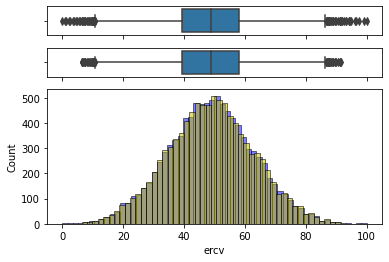

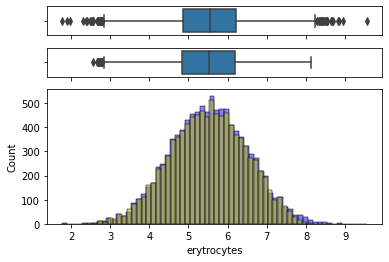

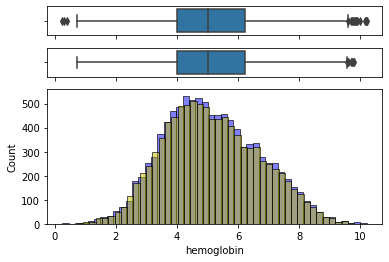

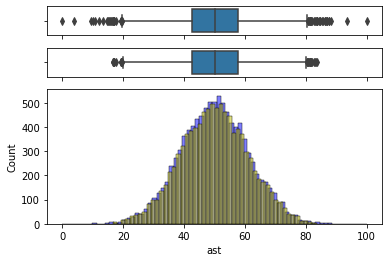

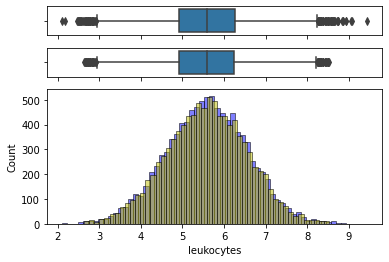

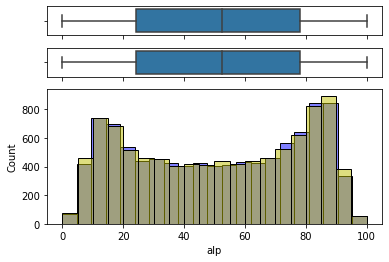

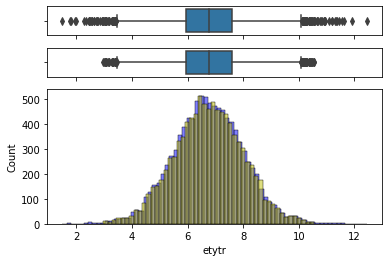

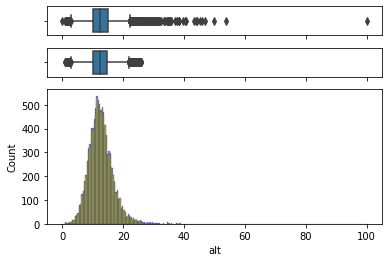

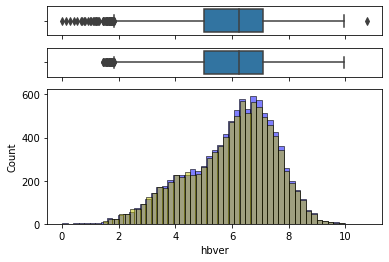

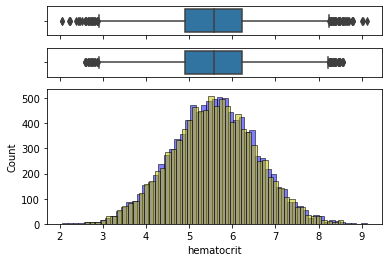

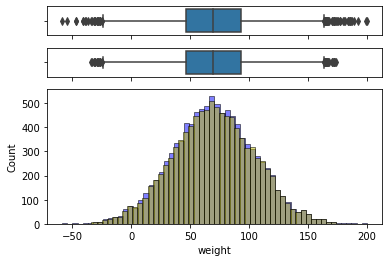

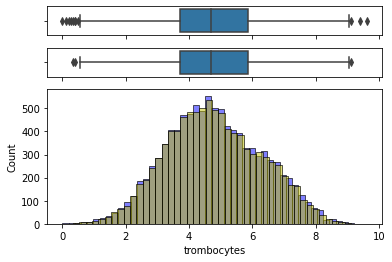

In [18]:
new_labor_std_remove = remove_outliers(num_labor, lower, upper)
    
shape_diff(num_labor, new_labor_std_remove)
dist_diff(num_labor, new_labor_std_remove)

##### 1.2.1.2  Nahradenie nájdených outlierov 5. a 95. kvantilom

Before: (10030, 12)
After: (10030, 12)


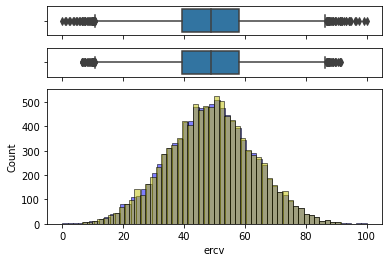

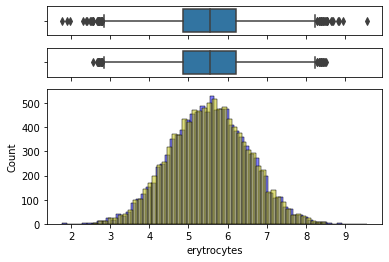

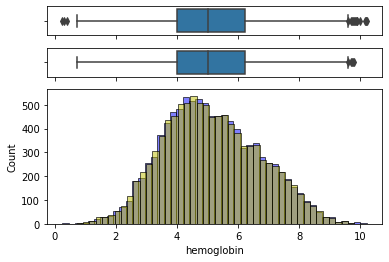

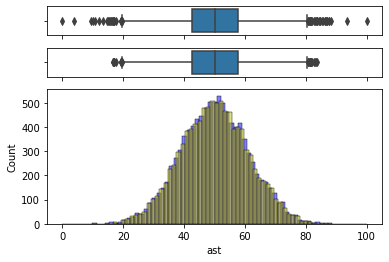

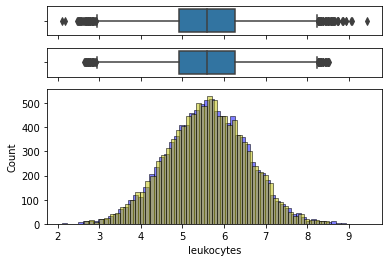

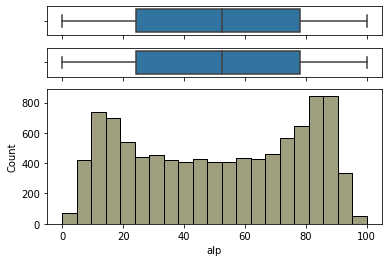

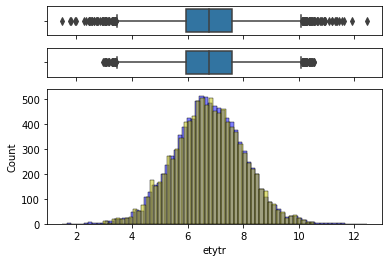

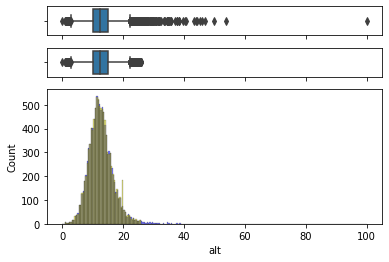

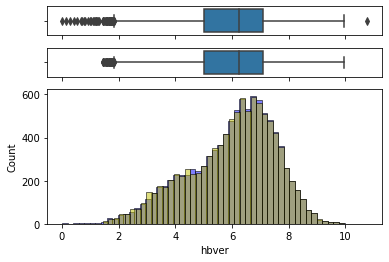

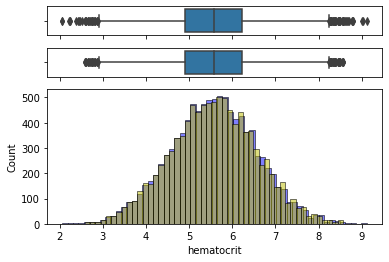

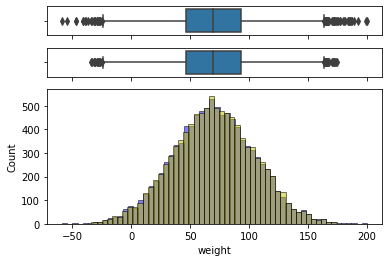

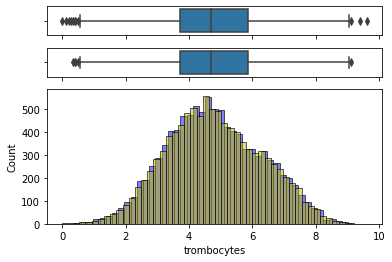

In [19]:
new_labor_std_replace = replace_outliers(num_labor, lower, upper, num_labor.quantile(q=0.05), num_labor.quantile(q=0.95))

shape_diff(num_labor, new_labor_std_replace)
dist_diff(num_labor, new_labor_std_replace)

#### 1.2.2  Interquartile Range Method

V tejto metóde detekujeme outlierov, ktorí sú od 25. a 75. kvantilu vzdialení o viac ako 1.5-násobok IQR, teda medzikvantilového priestoru.

In [20]:
q25, q75 = num_labor.quantile(q=0.25), num_labor.quantile(q=0.75)
iqr = q75 - q25

cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

print("COLUMN" + " "*14 + "Q25" + " "*22 + "Q75" + " "*22 + "LOWER" + " "*20 +"UPPER")
for i in numeric_cols:
    print(i + " "*(20-len(i)) + str(q25[i]) + " "*(25-len(str(q25[i]))) + str(q75[i]) + " "*(25-len(str(q75[i]))) + str(lower[i]) + " "*(25-len(str(lower[i]))) + str(upper[i]))

COLUMN              Q25                      Q75                      LOWER                    UPPER
ercv                39.2508675               58.157340000000005       10.891158749999988       86.51704875000001
erytrocytes         4.84936                  6.214315                 2.8019274999999997       8.2617475
hemoglobin          3.9887699999999997       6.234905                 0.6195674999999987       9.604107500000001
ast                 42.4725525               57.72875500000001        19.588248749999988       80.61305875000002
leukocytes          4.9233575                6.25343                  2.92824875               8.24853875
alp                 24.32141                 77.9715925               -56.15386375             158.44686625
etytr               5.9328925                7.598420000000001        3.4346012499999996       10.096711250000002
alt                 10.0459775               14.872452499999998       2.8062650000000016       22.112164999999997
hbver        

In [21]:
detect_outliers(num_labor, lower, upper)

ercv                outliers: 78
erytrocytes         outliers: 53
hemoglobin          outliers: 17
ast                 outliers: 56
leukocytes          outliers: 94
alp                 outliers: 0
etytr               outliers: 115
alt                 outliers: 290
hbver               outliers: 60
hematocrit          outliers: 75
weight              outliers: 68
trombocytes         outliers: 11


##### 1.2.2.1  Odstránenie nájdených outlierov

Before: (10030, 12)
After: (9172, 12)


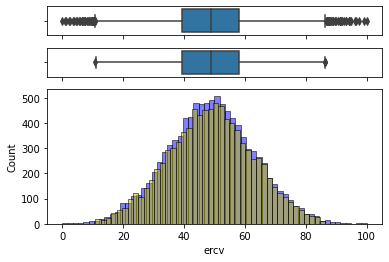

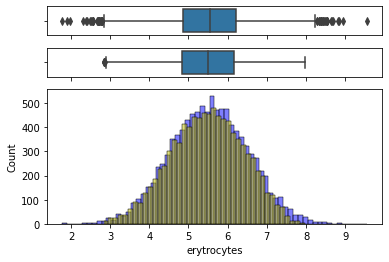

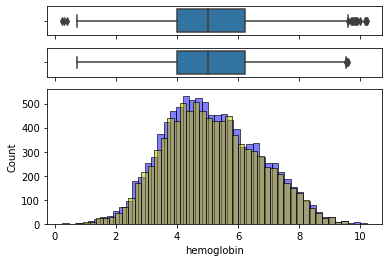

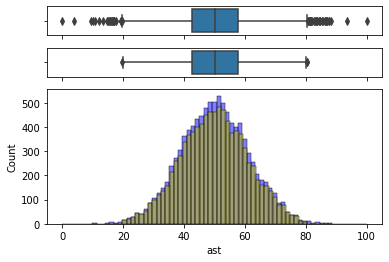

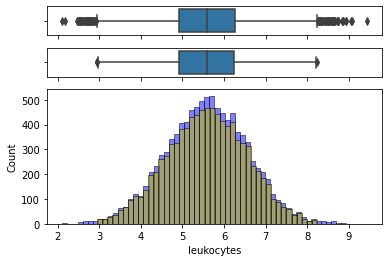

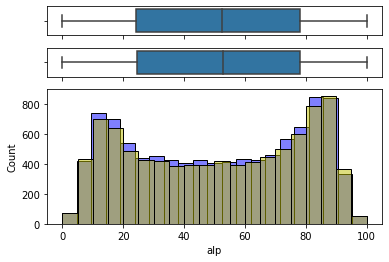

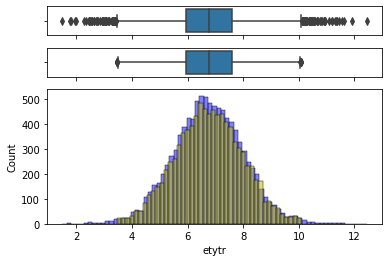

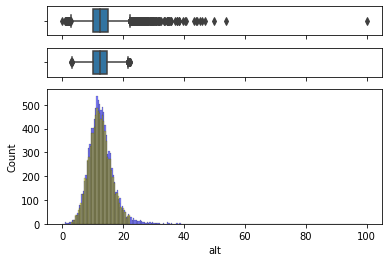

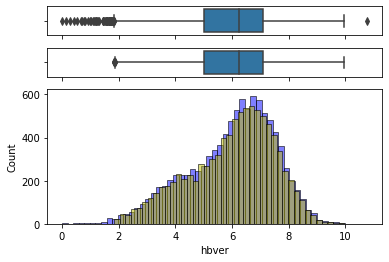

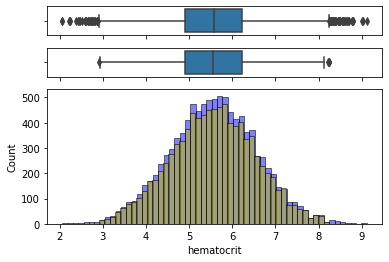

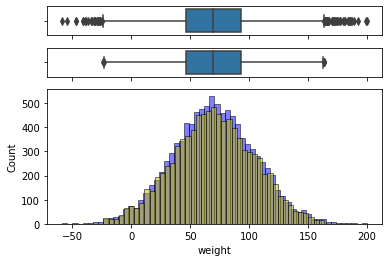

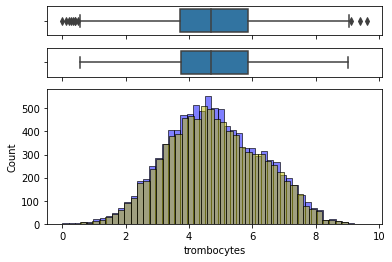

In [22]:
new_labor_iqr_remove = remove_outliers(num_labor, lower, upper)
    
shape_diff(num_labor, new_labor_iqr_remove)
dist_diff(num_labor, new_labor_iqr_remove)

##### 1.2.2.2  Nahradenie nájdených outlierov 5. a 95. kvantilom

Before: (10030, 12)
After: (10030, 12)


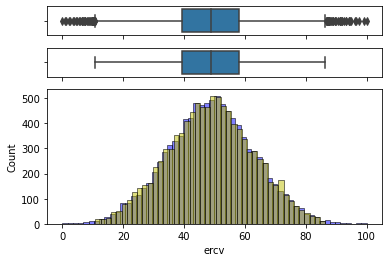

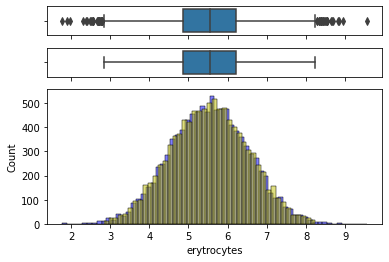

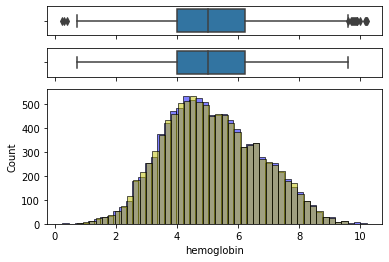

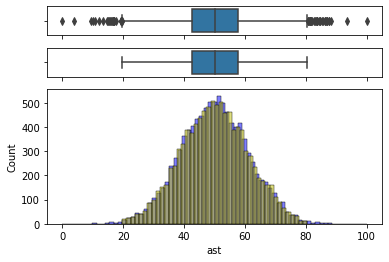

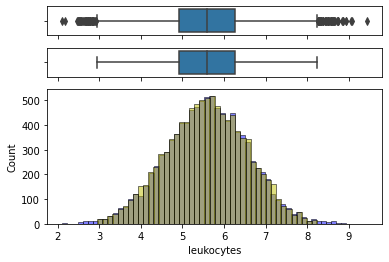

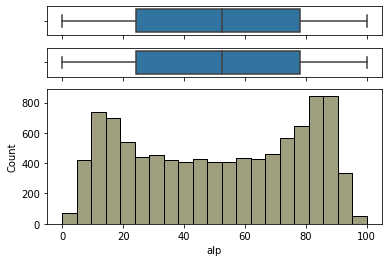

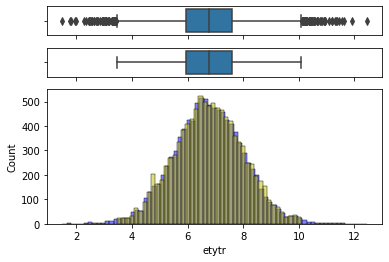

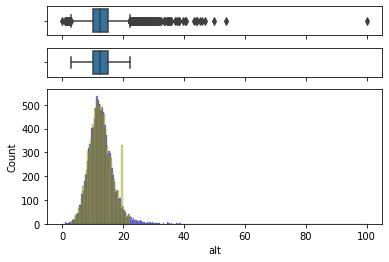

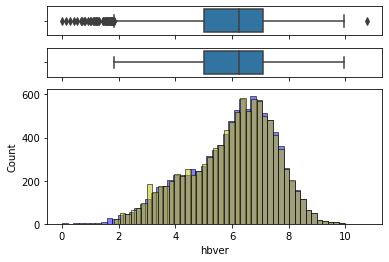

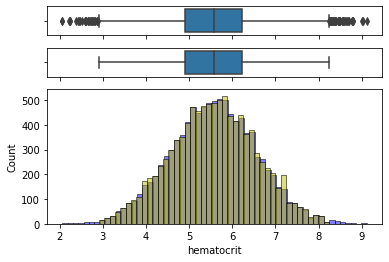

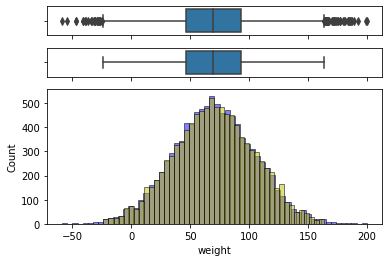

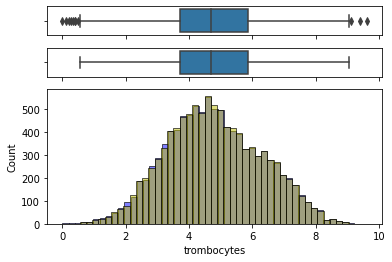

In [23]:
new_labor_iqr_replace = replace_outliers(num_labor, lower, upper, num_labor.quantile(q=0.05), num_labor.quantile(q=0.95))
    
shape_diff(num_labor, new_labor_iqr_replace)
dist_diff(num_labor, new_labor_iqr_replace)

#### 1.2.3  Závery
Pri spôsobe 3xSTD je outlierov o niečo menej. Pri nahradzovaní hodnôt percentilmi v metóde IQR sa z dôvodu veľkého počtu outlierov vytvoria výbežky na oboch stranách rozložení.
Vybrali sme si stratégiu 3xSTD spolu s nahradením 5. a 95. kvantilom.

In [24]:
num_labor = new_labor_std_replace
replace_in_df(numeric_cols, labor, num_labor)

## 2  Realizácia predspracovania dát

Spojíme oba datasety aby sme mohli skúmať aj niektoré kategorické atribúty z datasetu profiles.

In [25]:
merged = labor.merge(profiles, on='ssn', how='left')
merged = merged.drop(columns='ssn')

merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10030 entries, 0 to 10029
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ercv          10030 non-null  float64
 1   erytrocytes   10030 non-null  float64
 2   hemoglobin    10030 non-null  float64
 3   ast           10030 non-null  float64
 4   smoker        10030 non-null  object 
 5   relationship  10030 non-null  object 
 6   leukocytes    10030 non-null  float64
 7   alp           10030 non-null  float64
 8   etytr         10030 non-null  float64
 9   alt           10030 non-null  float64
 10  hbver         10030 non-null  float64
 11  indicator     10030 non-null  float64
 12  hematocrit    10030 non-null  float64
 13  weight        10030 non-null  float64
 14  trombocytes   10030 non-null  float64
 15  sex           10030 non-null  object 
 16  blood_type    10030 non-null  object 
 17  race          10030 non-null  object 
 18  age           10030 non-nu

### 2.1 Rozdelenie datasetu

Dataset si rozdelíme náhodne v pomere 75:25 na trénovaciu a testovaciu množinu.

In [26]:
train, test = train_test_split(merged, test_size=0.25)
train = pd.DataFrame(train)
test = pd.DataFrame(test)
print("Train: " + str(train.shape))
print("Test: " + str(test.shape))

Train: (7522, 19)
Test: (2508, 19)


### 2.1 Kódovanie - ordinal encoding

Zakódujeme stĺpce smoker, relationship, sex, blood_type a race pomocou jednoduchého encodera.

In [27]:
encoder = OrdinalEncoder(cols=['smoker', 'relationship', 'sex', 'blood_type', 'race'])
pipeline_enc = Pipeline(steps=[('encoder', encoder)])
train = pipeline_enc.fit_transform(train)

#pipeline_enc.named_steps['encoder'].mapping

for i in ['smoker', 'relationship', 'sex', 'blood_type', 'race']:
    print(i + (15 - len(i)) * " " + str(train[i].unique()))
train.loc[:,['smoker', 'relationship', 'sex', 'blood_type', 'race']].head()

smoker         [1 2]
relationship   [1 2 3 4 5]
sex            [1 2]
blood_type     [1 2 3 4 5 6 7 8]
race           [1 2 3 4 5]


c:\users\matus\appdata\local\programs\python\python39\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,smoker,relationship,sex,blood_type,race
5221,1,1,1,1,1
1364,1,2,2,2,2
618,1,3,1,3,3
753,2,4,1,4,3
8055,2,5,1,4,1


#### 2.2.1 Zhrnutie

Ďalej pracujeme s numerickými stĺpcami trénovacej množiny (kvôli škálovaniu a transformáciám). Pridávame aj stĺpec vek, ktorý sme vypočítali vo fáze 1.

In [28]:
num_train = pd.DataFrame(train.loc[:,numeric_cols + ['age']])

### 2.3 Škálovanie atribútov

#### 2.3.1 Standard scaler

Skúsime použiť standard scaler.

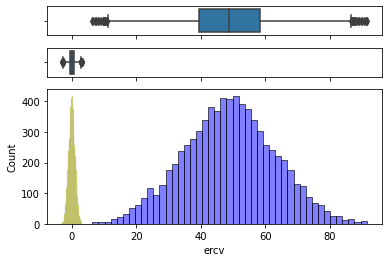

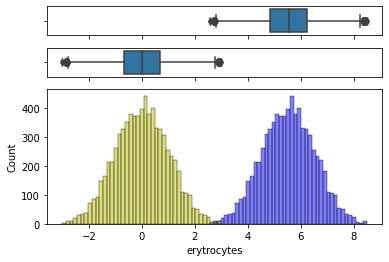

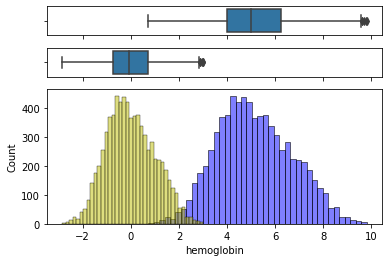

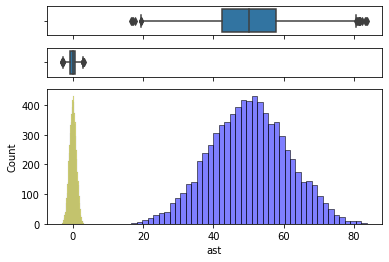

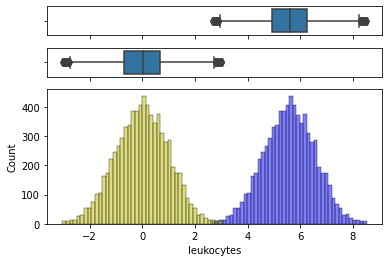

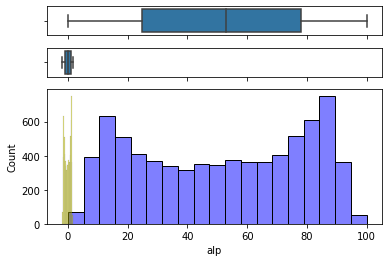

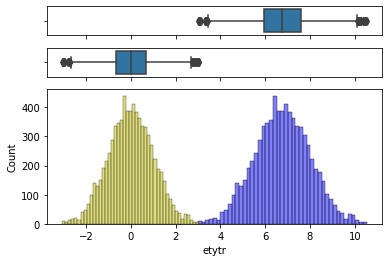

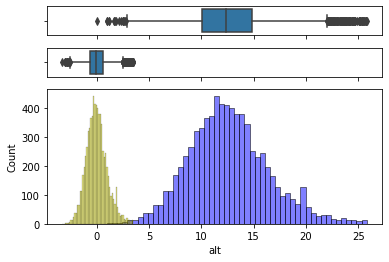

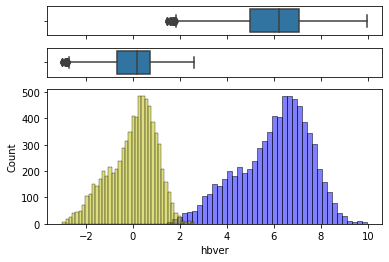

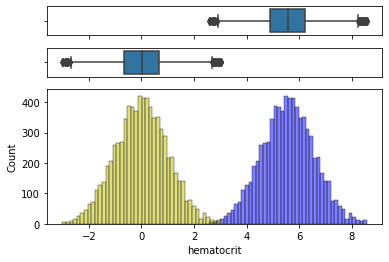

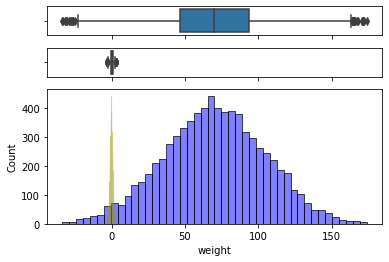

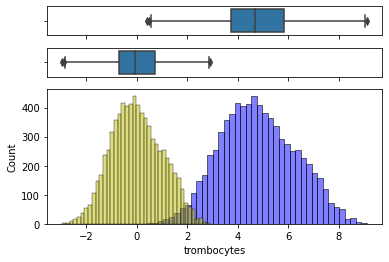

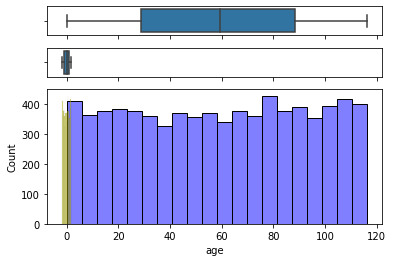

In [29]:
standard_scaler = StandardScaler()
pipeline_standard = Pipeline(steps=[('scaler', standard_scaler)])
scaled_train_standard = transform_with_pipe(pipeline_standard, num_train)

dist_diff(num_train, scaled_train_standard)

#### 2.3.2 Normalization

Skúsime použiť min-max scaler pre normalizáciu.

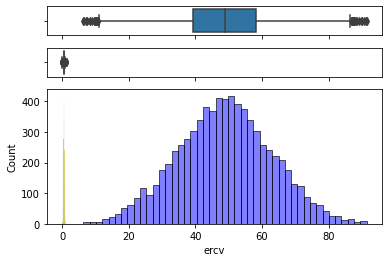

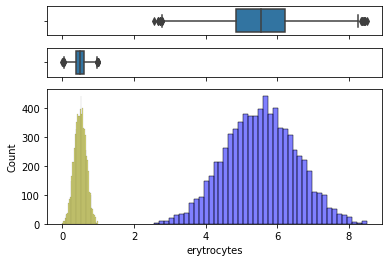

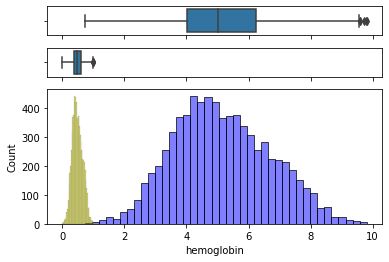

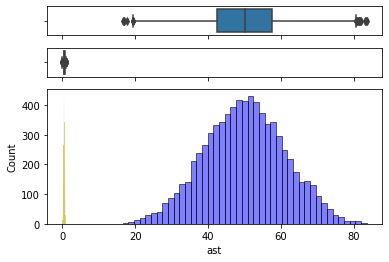

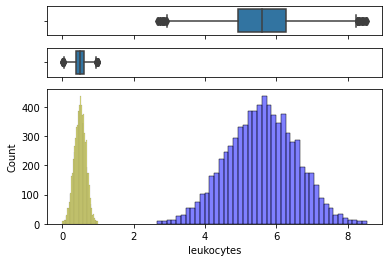

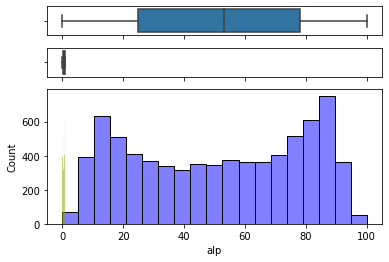

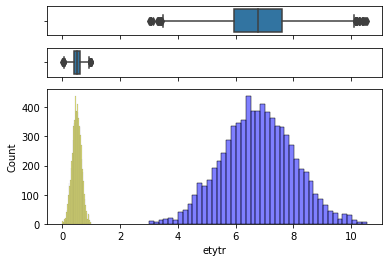

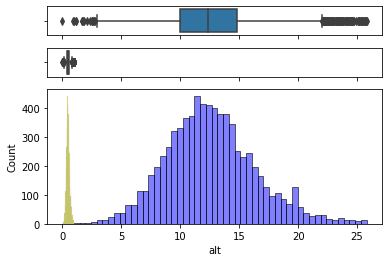

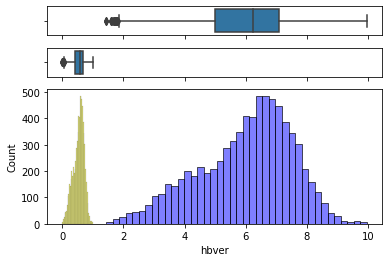

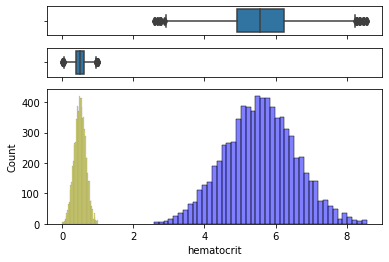

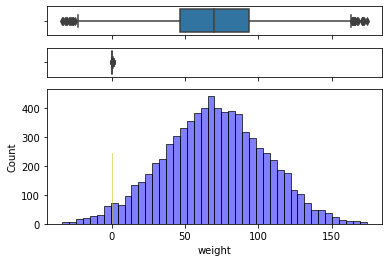

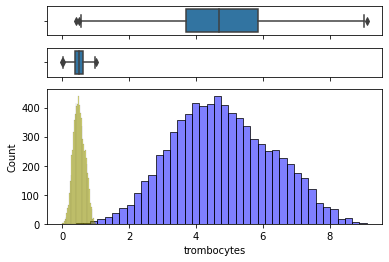

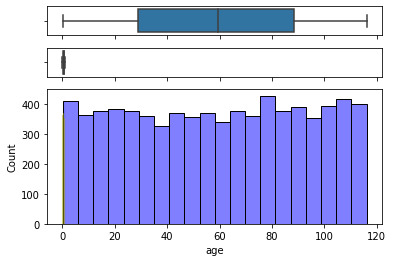

In [30]:
minmax_scaler = MinMaxScaler()
pipeline_minmax = Pipeline(steps=[('scaler', minmax_scaler)])
scaled_train_minmax = transform_with_pipe(pipeline_minmax, num_train)

dist_diff(num_train, scaled_train_minmax)

#### 2.3.3 Robustné škálovanie

Skúsime použiť robustné škálovanie.

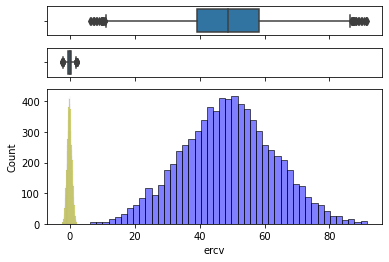

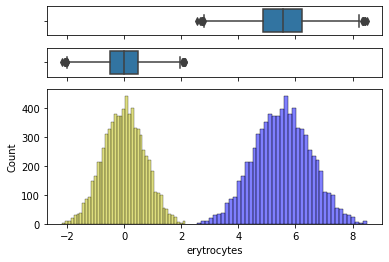

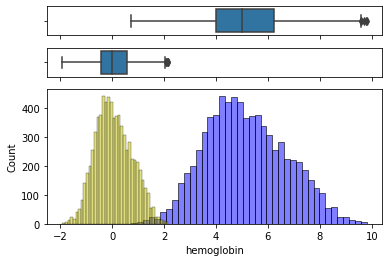

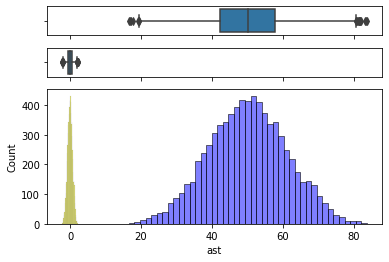

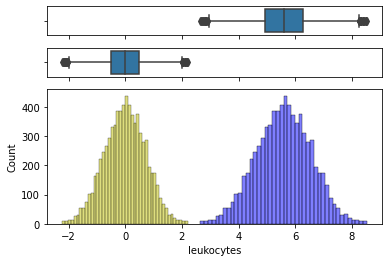

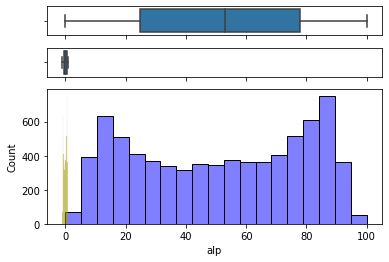

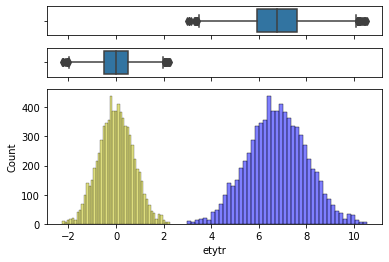

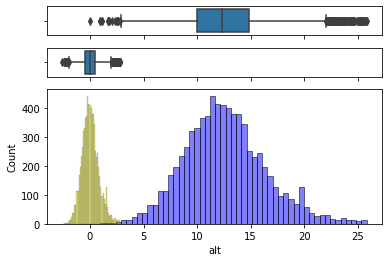

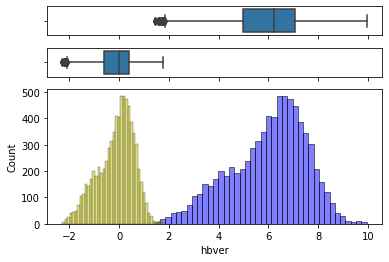

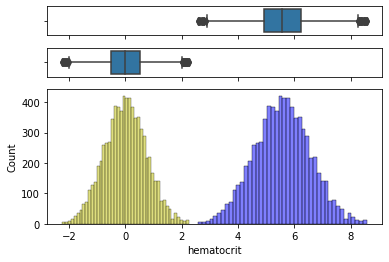

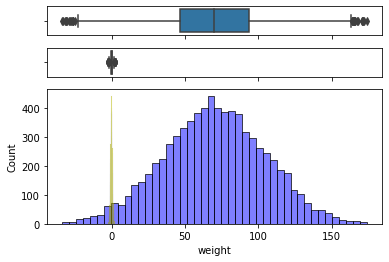

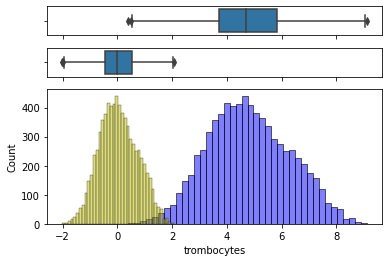

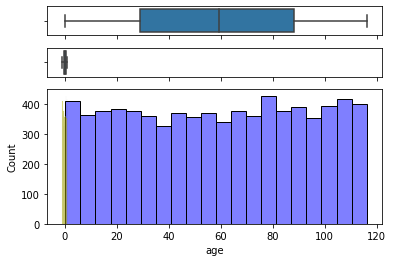

In [31]:
robust_scaler = RobustScaler()
pipeline_robust = Pipeline(steps=[('scaler', robust_scaler)])
scaled_train_robust = transform_with_pipe(pipeline_robust, num_train)

dist_diff(num_train, scaled_train_robust)

#### 2.3.2 Zhrnutie

Výsledky štandardného a robustného škálovania sú veľmi podobné, rovnako aj min-max, no tam je interval rozložený doprava od nuly. Rozhodli sme sa použiť robustné škálovanie.

In [32]:
num_train = scaled_train_robust

### 2.4 Transformácia atribútov

Najskôr zistíme, ktoré atribúty nemajú normálne rozdelenie.

In [33]:
def print_shapiro(df, s):
    print("COLUMN" + ' '*14 + "P-VALUE")
    for i in df:
        if (s == None):
            stat, p = stats.shapiro(df.loc[:,i].sample(n=1000))
        else:
            stat, p = stats.shapiro(df.loc[:,i].sample(n=1000, random_state=s))
        print(i + ' ' * (20 - len(i)) + str(p))

In [34]:
print_shapiro(num_train, 1)

COLUMN              P-VALUE
ercv                0.19855022430419922
erytrocytes         0.01539701223373413
hemoglobin          1.5754939113321598e-06
ast                 0.08747616410255432
leukocytes          0.6188876032829285
alp                 8.042574506070086e-22
etytr               0.2837088108062744
alt                 0.0512537807226181
hbver               5.40265228388126e-12
hematocrit          0.30598020553588867
weight              0.32006004452705383
trombocytes         0.0007386873476207256
age                 3.8428193232574935e-18


Mnoho atribútov nemá rovnomerné rozdelenie, pričom vyskúšame použiť rôzne transformácie.

#### 2.4.1 Power transformer

COLUMN              P-VALUE
ercv                0.19132159650325775
erytrocytes         0.01690089888870716
hemoglobin          0.001057696994394064
ast                 0.08278921246528625
leukocytes          0.6608381271362305
alp                 8.46731185869948e-22
etytr               0.22098584473133087
alt                 0.01072107907384634
hbver               8.103651634883136e-05
hematocrit          0.24487946927547455
weight              0.2606547772884369
trombocytes         0.0026483130641281605
age                 3.874382881071292e-18


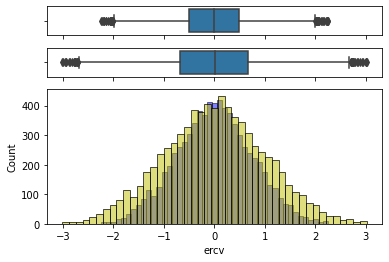

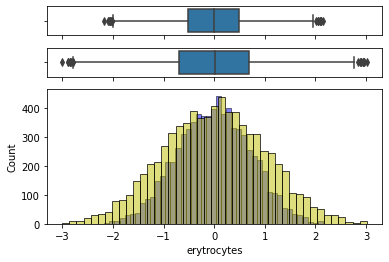

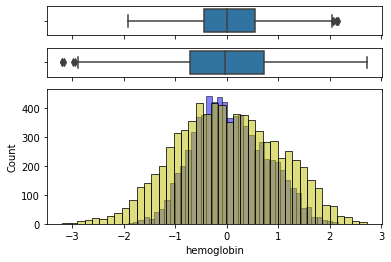

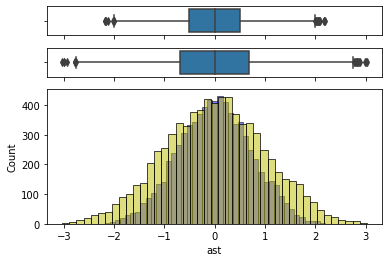

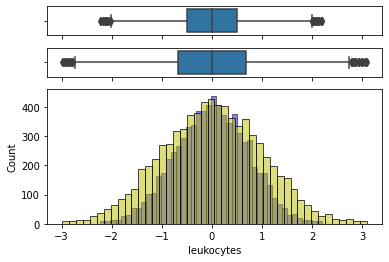

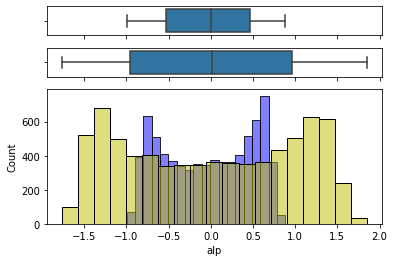

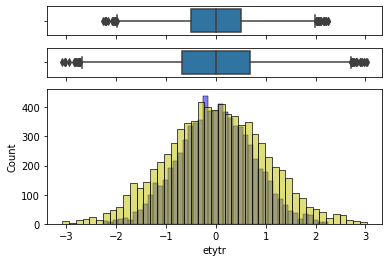

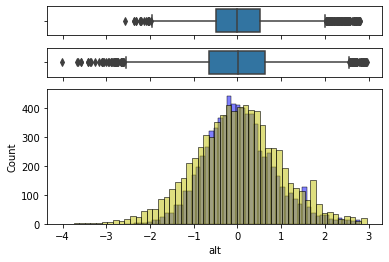

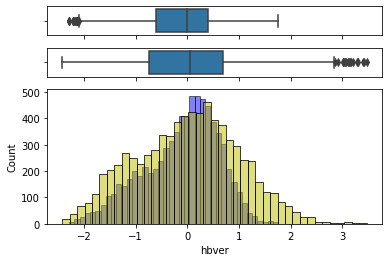

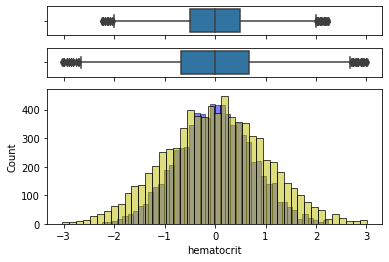

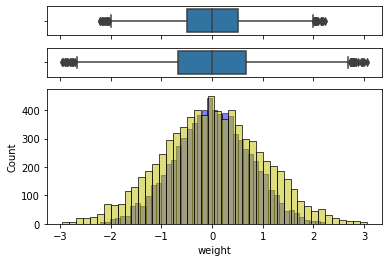

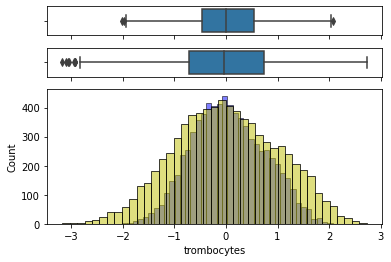

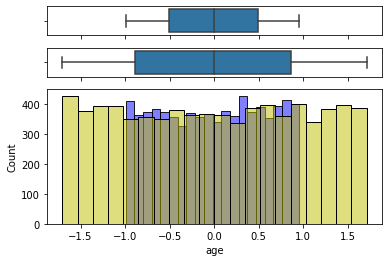

In [35]:
power_transformer = PowerTransformer(method='yeo-johnson', standardize=True) 

pipeline_power = Pipeline(steps=[('transformer', power_transformer)])
transformed_train_yeo = transform_with_pipe(pipeline_power, num_train)

dist_diff(num_train, transformed_train_yeo)

print_shapiro(transformed_train_yeo, 1)

#### 2.4.2 Quantile transformer

COLUMN              P-VALUE
ercv                1.7653553641139297e-07
erytrocytes         1.2563224115538785e-12
hemoglobin          5.796547686287568e-10
ast                 3.6999150410110815e-09
leukocytes          1.329487520074224e-09
alp                 1.9330639519643533e-11
etytr               6.010467679118392e-09
alt                 4.1484676804870446e-10
hbver               4.3614167832828343e-11
hematocrit          2.1067089051030052e-07
weight              2.333027993017822e-09
trombocytes         3.4060076807562734e-12
age                 0.003999404143542051


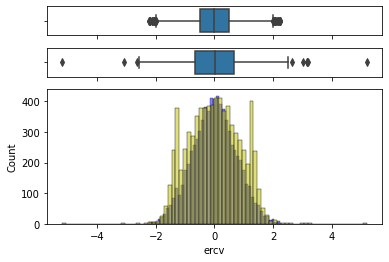

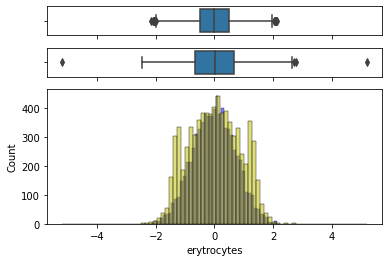

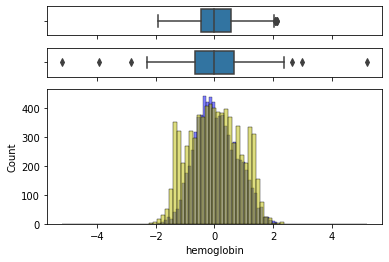

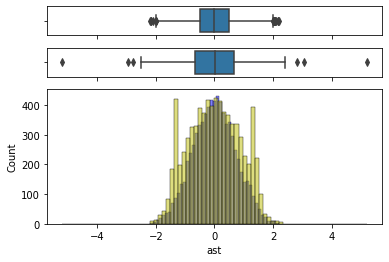

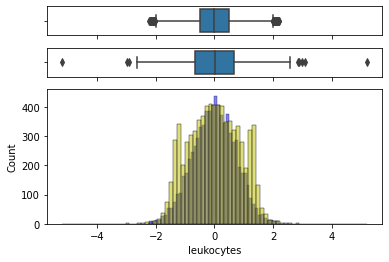

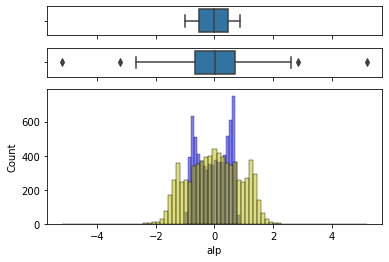

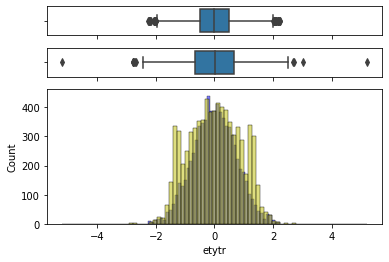

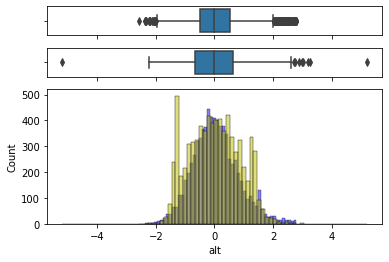

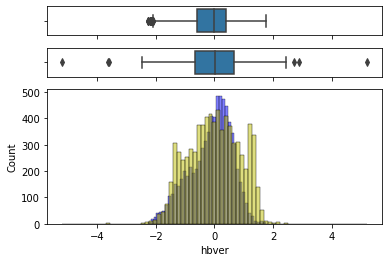

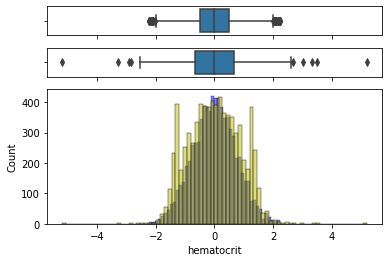

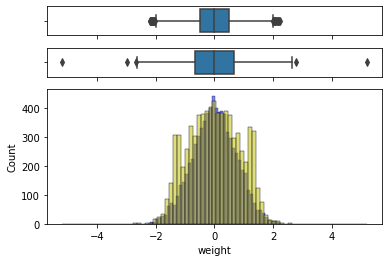

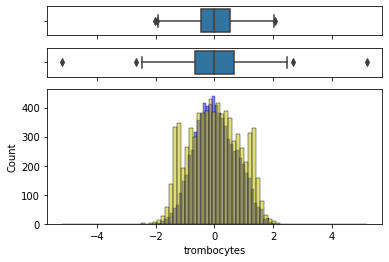

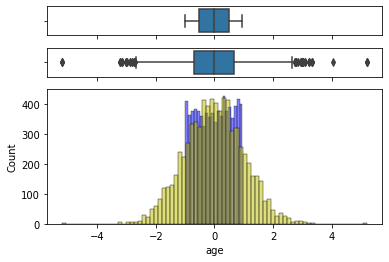

In [36]:
qt_transformer = QuantileTransformer(n_quantiles=10, random_state=0, output_distribution='normal')

pipeline_qt = Pipeline(steps=[('transformer', qt_transformer)])
transformed_train_qt = transform_with_pipe(pipeline_qt, num_train)

dist_diff(num_train, transformed_train_qt)
print_shapiro(transformed_train_qt, 1)


#### 2.4.3 Zhrnutie

Kvantilový tranformátor neposkytol dobré výsledky, power tranformátor rozloženia o niečo zlepšil aj keď niektoré stále nedosahujú p-value 0.05. Rozhodli sme sa pre power tranformátor metódou yeo-johnson.

In [37]:
replace_in_df(numeric_cols+['age'], num_train, transformed_train_yeo)
replace_in_df(numeric_cols+['age'], train, num_train)

## 3  Výber atribútov pre strojové učenie

In [38]:
indicator = train['indicator']
train_select = train.drop(columns=['indicator'])

Funkcie na zobrazenie výsledkov.

In [39]:
def get_all_columns(df, scores):
    tuples = []
    for i in range(len(df.columns)):
        tuples.append((scores[i], df.columns[i]))
    tuples.sort(key= lambda x:abs(x[0]), reverse=True)
    for i in tuples:
        print(str(i[1]) + " "*((20 if (i[0] >= 0) else 19)-len(str(i[1]))) + str(i[0]))
    print()

def get_best_columns(df,action):
    cols = action.get_support(indices=True)
    cols = df.iloc[:,cols].columns
    print("Selected features:")
    for i in cols:
        print(" " + i)

### 3.1  Variance threshold

Skontrolujeme, či majú všetky atribúty dostatočnú varianciu.

In [40]:
print(train_select.var())
print()

var_transformer = VarianceThreshold(threshold=0.1)

pipeline_var = Pipeline(steps=[('variance_threshold', var_transformer)])
transformed_train_var = transform_with_pipe(pipeline_var, train_select)

shape_diff(train_select, transformed_train_var)


ercv            1.000133
erytrocytes     1.000133
hemoglobin      1.000133
ast             1.000133
smoker          0.238607
relationship    1.353971
leukocytes      1.000133
alp             1.000133
etytr           1.000133
alt             1.000133
hbver           1.000133
hematocrit      1.000133
weight          1.000133
trombocytes     1.000133
sex             0.250028
blood_type      5.358638
race            0.836428
age             1.000133
dtype: float64

Before: (7522, 18)
After: (7522, 18)


Všetky atribúty majú dostačujúcu varianciu.

### 3.2 Filtrovacie metódy

####  3.2.1 Mutual information

In [41]:
estimator = SelectKBest(mutual_info_regression, k=10)

pipeline_estimator = Pipeline(steps=[('estimator', estimator)])
pipeline_estimator.fit(train_select, indicator);

get_all_columns(train_select, estimator.scores_)
get_best_columns(train_select, estimator)

trombocytes         0.0856550567653187
hemoglobin          0.07812633950138803
hbver               0.07338999482626285
alp                 0.026515385572007943
alt                 0.00849825664987236
leukocytes          0.007348681928677436
sex                 0.005758975453439064
etytr               0.004710536683749211
erytrocytes         0.004222386975245129
ercv                0.0017377283313919634
ast                 0.000404638524869938
smoker              0.0
relationship        0.0
hematocrit          0.0
weight              0.0
blood_type          0.0
race                0.0
age                 0.0

Selected features:
 ercv
 erytrocytes
 hemoglobin
 leukocytes
 alp
 etytr
 alt
 hbver
 trombocytes
 sex


In [42]:
estimator = SelectKBest(f_regression, k=10)

pipeline_estimator = Pipeline(steps=[('estimator', estimator)])
pipeline_estimator.fit(train_select, indicator);

get_all_columns(train_select, estimator.scores_)
get_best_columns(train_select, estimator)

trombocytes         986.652227167972
hemoglobin          971.4004479821812
hbver               924.8279650842488
alp                 392.67530498162927
sex                 3.4468634989258455
age                 3.144170002535355
alt                 1.701153426461026
ercv                0.7605295712731717
leukocytes          0.7123233687670502
hematocrit          0.656365648147983
etytr               0.6431941956624041
relationship        0.3792922218906914
erytrocytes         0.01990140603233177
smoker              0.015049710771360568
ast                 0.012062185727483294
race                0.011827745643462506
weight              0.011248007418666547
blood_type          0.00013576639369886274

Selected features:
 ercv
 hemoglobin
 leukocytes
 alp
 alt
 hbver
 hematocrit
 trombocytes
 sex
 age


### 3.3 Wrapper

#### 3.3.1 RFE

In [43]:
estimator = LogisticRegression(solver='lbfgs', max_iter=1000)
selector = RFE(estimator, n_features_to_select=10, step=1)
pipeline_selector = Pipeline(steps=[('selector', selector)])
pipeline_selector.fit(train_select, indicator);

for i in range(len(train_select.columns)):
    print(train_select.columns[i] + " "*(20-len(train_select.columns[i])) + str(selector.support_[i]) + " "*(10-len(str(selector.support_[i]))) + str(selector.ranking_[i]))
    
print()

tuples = []
for i in range(len(selector.get_support(indices=True))):
    tuples.append((selector.estimator_.coef_[0][i], train_select.columns[selector.get_support(indices=True)[i]]))
tuples.sort(key= lambda x:abs(x[0]) , reverse=True)
for i in tuples:
    print(str(i[1]) + " "*((20 if (i[0] >= 0) else 19)-len(str(i[1]))) + str(i[0]))
print()

get_best_columns(train_select, selector)

ercv                False     8
erytrocytes         True      1
hemoglobin          True      1
ast                 False     5
smoker              True      1
relationship        False     4
leukocytes          False     2
alp                 True      1
etytr               True      1
alt                 True      1
hbver               True      1
hematocrit          True      1
weight              False     7
trombocytes         True      1
sex                 False     3
blood_type          False     9
race                False     6
age                 True      1

hbver              -1.7255680638227204
hemoglobin          1.4820854489189355
trombocytes        -0.7830097703137137
alp                 0.35959421514979817
etytr              -0.31713371674137386
hematocrit          0.07078885146169342
age                 0.04917334687746526
alt                -0.041259188485721056
erytrocytes         0.0332215011001044
smoker              0.028572796476878392

Selected features:
 eryt

### 3.4 SelectFromModel

#### 3.4.1 Model Logistickej regresie

In [44]:
estimator = LogisticRegression(solver='lbfgs', max_iter=1000)
selector = SelectFromModel(estimator)
pipeline_selector = Pipeline(steps=[('selector', selector)])
pipeline_selector.fit(train_select, indicator);
    
print('Threshold: ' + str(selector.threshold_))
print()

get_all_columns(train_select, selector.estimator_.coef_[0])
get_best_columns(train_select, selector)

Threshold: 0.27766352713020226

hbver              -1.7264207118371726
hemoglobin          1.483528332500124
trombocytes        -0.7832837252503458
alp                 0.3590610670088075
etytr              -0.317027144460656
hematocrit          0.07162450040525833
age                 0.04911314794788101
alt                -0.04218182498075227
erytrocytes         0.03427824416564636
smoker              0.03007359969450693
leukocytes         -0.024590650309693395
sex                -0.023739564994076714
relationship       -0.015393717956305272
ast                -0.015218876850076795
race               -0.008767405673869785
weight              0.006165676689002879
ercv                0.005899033899181867
blood_type         -0.0015762637202836158

Selected features:
 hemoglobin
 alp
 etytr
 hbver
 trombocytes


#### 3.4.2 L1-based selekcia atribútov

In [45]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False)
selector = SelectFromModel(estimator=lsvc)
pipeline_selector = Pipeline(steps=[('selector', selector)])
pipeline_selector.fit(train_select, indicator);
    
print('Threshold: ' + str(selector.threshold_))
print()

get_all_columns(train_select, selector.estimator_.coef_[0])
get_best_columns(train_select, selector)

Threshold: 1e-05

hbver              -0.5679849106558092
hemoglobin          0.48569535372025996
trombocytes        -0.21572185501680083
alp                 0.12383243877432804
etytr              -0.0965182318849858
smoker              0.02157601386382679
hematocrit          0.013661781225883726
race                0.012095987429870914
sex                 0.010172495856325103
age                 0.009363474513790715
relationship        0.007825202420060623
blood_type          0.005840613739725987
alt                -0.0012324484129311096
ercv                0.0
erytrocytes         0.0
ast                 0.0
leukocytes          0.0
weight              0.0

Selected features:
 hemoglobin
 smoker
 relationship
 alp
 etytr
 alt
 hbver
 hematocrit
 trombocytes
 sex
 blood_type
 race
 age


Pri použití viacerých techník vznikli rôzne výsledky. Top 5 atribútov (z celkových 18) bolo pri väčšine rovnakých, podľa poradia:
1. hbver
2. hemoglobin
3. trombocytes
4. alp
5. etytr

Ďalšie atrubúty, ktoré sa často vyskytli v TOP 10:
- hematocrit
- age
- erytrocytes
- relationship
- ast
- sex
- smoker

## 4  Replikovateľnosť predspracovania

In [46]:
def transform_all(df):
    pipeline = Pipeline(steps=[('encoder', OrdinalEncoder(cols=['smoker', 'relationship', 'sex', 'blood_type', 'race']))])
    transformed_df = transform_with_pipe(pipeline, df)
    num_df = pd.DataFrame(transformed_df.loc[:,numeric_cols + ['age']])
    pipeline = Pipeline(steps=[
        ('scaler', RobustScaler()),
        ('transformer', PowerTransformer(method='yeo-johnson', standardize=True)),
                              ])
    transformed_num_df = transform_with_pipe(pipeline, num_df)
    new_df = pd.DataFrame(df)
    replace_in_df(['smoker', 'relationship', 'sex', 'blood_type', 'race'], new_df, transformed_df)
    replace_in_df(numeric_cols + ['age'], new_df, transformed_num_df)
    return new_df

Aplikujeme transformácie na oba datasety a spojíme ich.

In [47]:
train_export = transform_all(train)
test_export = transform_all(test)

c:\users\matus\appdata\local\programs\python\python39\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
c:\users\matus\appdata\local\programs\python\python39\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [48]:
print(train_export.shape)
print(test_export.shape)

(7522, 19)
(2508, 19)


Nakoniec exportujeme

In [49]:
train_export.to_csv('./faza_2_train.csv', index = False, header=True, sep=';')
test_export.to_csv('./faza_2_test.csv', index = False, header=True, sep=';')